<a href="https://colab.research.google.com/github/cgcggg/cgcggg.github.io/blob/master/14_07_Multi_classification(MNIST)_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Deep Neural Networks

## Load MNIST Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. MNIST 데이터 로드 및 확인

In [3]:
from torchvision import datasets, transforms

In [4]:
# MNIST 데이터 다운로드

# train set : tensor 형태로 불러오기
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

# test set : tensor 형태로 불러오기
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 손글씨 이미지를 출력해주는 함수
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

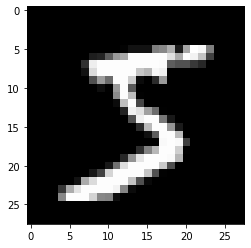

In [6]:
# 학습 셋의 첫번째 손글씨 이미지 확인
plot(train.data[0])

# 2. 데이터 전처리

In [7]:
# 피처 : Minmax scaling
x = train.data.float() / 255.

# 타깃값 로드
y = train.targets

In [8]:
# 피처 -> view로 차원 변환 (60000,  28x28 -> 784)
x = x.view(x.size(0), -1)

print(x.shape)
print(y.shape)

torch.Size([60000, 784])
torch.Size([60000])


In [9]:
# 입력 차원, 출력 차원 확인
input_size = x.size(-1)          # input_size : 784
output_size = int(max(y)) + 1    # output_size : 10

print('input_size: %d, output_size: %d' % (input_size, output_size))

input_size: 784, output_size: 10


# 3. 데이터 분리

In [10]:
# Train / Valid ratio (테스트 셋은 별도 존재)
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 48000 / Valid 12000 / Test 10000 samples.


In [11]:
# 데이터 셔플링
indices = torch.randperm(x.size(0))
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

# 셔플링된 데이터를 train, valid로 분리하고 리스트로 저장
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

# test 데이터도 minmax scale, flatten(28x28차원->784차원) 후 리스트에 추가
x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [12]:
y[0][1]

tensor(4)

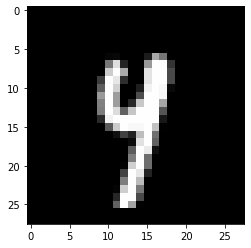

In [13]:
plot(x[0][1])

# 4. Build Model & Optimizer

In [24]:
model = nn.Sequential(
    nn.Linear(input_size, 400),    # 784차원 입력 데이터를 500차원으로
    nn.LeakyReLU(),
    nn.Linear(400, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 70),
    nn.LeakyReLU(),
    nn.Linear(70, 40),
    nn.LeakyReLU(),
    nn.Linear(40, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, output_size),    # 50차원 데이터를 -> 아웃풋 10차원으로
    nn.LogSoftmax(dim=-1),         # Final activation function은 log-softmax
)

model

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=100, out_features=70, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=70, out_features=40, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=40, out_features=20, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=20, out_features=15, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
  (14): Linear(in_features=15, out_features=10, bias=True)
  (15): LogSoftmax(dim=-1)
)

In [26]:
# 오차 함수는 NLL Loss
crit = nn.NLLLoss()

In [27]:
# optimizer는 adam
optimizer = optim.Adam(model.parameters())

# 5. device 지정(cpu or gpu)

In [28]:
# device 기본은 cpu
device = torch.device('cpu')

# 만약 cuda(gpu)가 존재하면 device로 cuda 사용(cuda : Nvidia에서 만든 GPU 엔진)
if torch.cuda.is_available():  
    device = torch.device('cuda')

In [29]:
import torch
torch.cuda.get_device_name('cuda')

'Tesla T4'

In [30]:
# 모델을 device로 보내고,
model = model.to(device)

# 데이터들도 device로 보낸다.
x = [x_i.to(device) for x_i in x]  
y = [y_i.to(device) for y_i in y]

# 6. Train

In [31]:
n_epochs = 1000
batch_size = 256

In [32]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [33]:
%%time
train_history, valid_history = [], []

# 첫번째 for문은 epoch을 위한 for문이고,
for i in range(n_epochs):
    # 학습 데이터(48000)에 대해서 랜덤 셔플링하고,
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
        
    # 미니배치 size로 split해준다.
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    # 두번째 for문은 미니배치를 위한 for문
    for x_i, y_i in zip(x_, y_):
        
        # 모델 학습
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())  # 오차 함수는 NLL Loss

        optimizer.zero_grad()     # parameter들의 grad를 0으로 초기화
        loss.backward()           # loss 함수를 parameter로 편미분  -> parameter들의 grad를 구하게 된다.

        optimizer.step()          # 한걸음 걸어간다 : parameter 업데이트(LR x gradient 이용)
        train_loss += float(loss) # loss를 float로 만들어 total loss를 계산한다.

    train_loss = train_loss / len(x_)
    
    # validation 시작(valid, test는 학습 x -> no_grad)
    # You need to declare to PYTORCH to stop build the computation graph.
    with torch.no_grad():
        
        # You don't need to shuffle the validation set.
        # Only split is needed.
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)  # validation은 loss까지만 구하고 끝(backward는 안함)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    # Log each loss to plot after training is done.
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    # 학습 진행상황 print
    if (i + 1) % 10 == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    # 만약 best model일 경우 : valid loss check -> 파라미터 저장
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i  # lowest_epoch은 best loss 일 때의 epoch
        
        # 'state_dict()' returns model weights as key-value.
        # Take a deep copy, if the valid loss is lowest ever.
        best_model = deepcopy(model.state_dict())   # best model 파라미터를 copy해서 저장
        
    # best model이 아닐 경우 : early stop check -> 학습 중단
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break  # early_stop에 해당하는 경우 학습 종료

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model.
model.load_state_dict(best_model)

Epoch 10: train loss=4.4066e-02  valid_loss=1.1687e-01  lowest_loss=1.1932e-01
Epoch 20: train loss=1.6894e-02  valid_loss=1.4912e-01  lowest_loss=1.1632e-01
Epoch 30: train loss=1.1704e-02  valid_loss=1.5578e-01  lowest_loss=1.1632e-01
Epoch 40: train loss=6.2512e-03  valid_loss=1.4001e-01  lowest_loss=1.1632e-01
Epoch 50: train loss=7.0883e-03  valid_loss=1.6469e-01  lowest_loss=1.1632e-01
Epoch 60: train loss=6.4234e-05  valid_loss=1.7112e-01  lowest_loss=1.1632e-01
There is no improvement during last 50 epochs.
The best validation loss from epoch 13: 1.1632e-01
CPU times: user 32.1 s, sys: 525 ms, total: 32.6 s
Wall time: 32.5 s


# 7. 학습 과정 확인

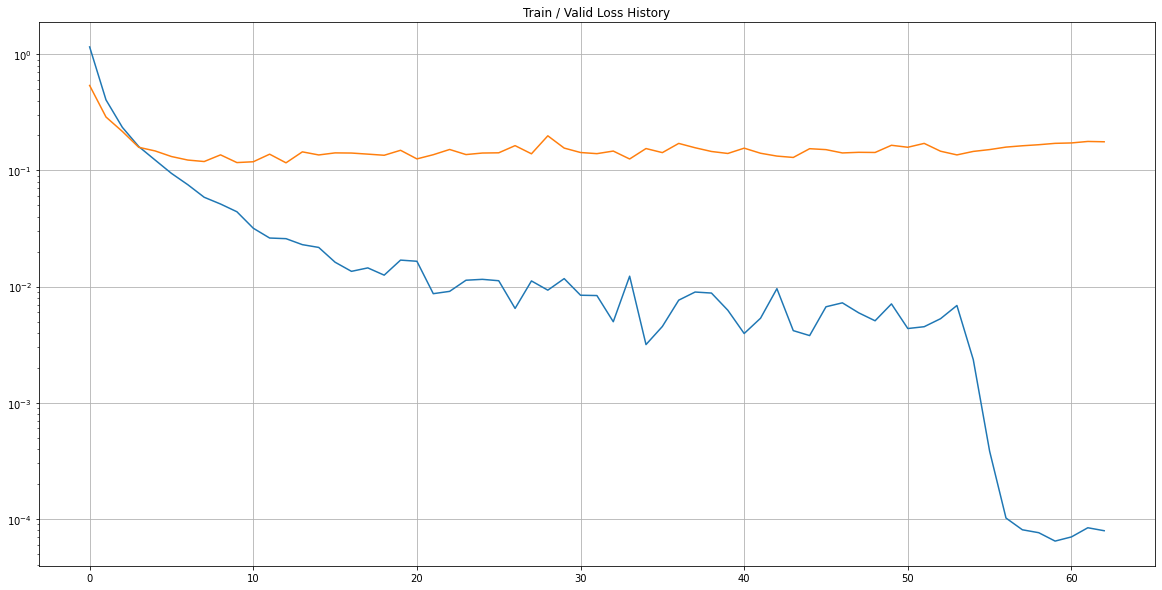

In [34]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

# 8. test 데이터 평가

In [35]:
test_loss = 0
y_hat = []

# test 시작(valid, test는 학습 x -> no_grad)
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 1.2141e-01


In [36]:
# test 데이터 정답
y[-1][0:3]

tensor([7, 2, 1], device='cuda:0')

In [37]:
# test 데이터 클래스별 확률값
print(y_hat.shape)
print(y_hat[0])
print(y_hat[1])
print(y_hat[2])

torch.Size([10000, 10])
tensor([-2.7039e+01, -1.1191e+01, -1.5516e+01, -1.1192e+01, -1.7966e+01,
        -3.4966e+01, -3.1817e+01, -8.5350e-05, -1.5413e+01, -9.7666e+00],
       device='cuda:0')
tensor([-1.4512e+01, -1.2883e+01, -1.4901e-05, -1.2478e+01, -2.1641e+01,
        -1.5418e+01, -1.2977e+01, -2.0029e+01, -1.2093e+01, -2.6804e+01],
       device='cuda:0')
tensor([-2.1400e+01, -4.7374e-04, -1.5449e+01, -8.9968e+00, -1.7318e+01,
        -1.1056e+01, -2.6875e+01, -8.6403e+00, -1.0398e+01, -8.9761e+00],
       device='cuda:0')


In [38]:
# test 데이터 예측값
torch.argmax(y_hat, dim=-1)

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [39]:
# 정확도 = 정답 수 / 전체 수 
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))
# 10000개 중 0000개 맞춤

Accuracy: 0.9715


# 9. confusion matrix 구해보기

In [40]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [44]:
pd.DataFrame(confusion_matrix(y[-1].cpu(), torch.argmax(y_hat.cpu(), dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,967,0,0,0,0,1,7,1,2,2
true_1,0,1118,1,2,0,1,2,4,5,2
true_2,2,0,1003,3,0,1,2,9,12,0
true_3,0,1,4,976,0,14,0,4,8,3
true_4,2,2,1,0,942,0,14,3,2,16
true_5,6,0,0,7,1,867,3,1,4,3
true_6,6,2,2,0,4,3,938,0,3,0
true_7,0,6,7,3,0,0,0,1002,3,7
true_8,3,1,5,3,6,15,3,6,927,5
true_9,2,3,0,2,9,8,1,6,3,975
